In [1]:
# %pip install yfinance
import pandas as pd
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
import re 

In [2]:
# Manual inputs
TIMEFRAME = "1d"
LOOKBACK_PERIOD = "5y"

In [3]:
def get_list():
    tickers_txt = open("TradingView Watchlists/2. Crnt. Portfolio.txt", "r")
    tickers = tickers_txt.read().splitlines()
    tickers_txt.close()
    UNIVERSE = re.findall(":[A-Z]{1,5}", str(tickers)) # A ticker has 1-5 capital letters (Max: 5 chars for NYSE, 4 chars for NASDAQ)
    UNIVERSE = [ticker[1:] for ticker in UNIVERSE] # Remove the colon from the ticker
    return UNIVERSE

UNIVERSE = get_list()
print(UNIVERSE)


['SPY', 'MSFT', 'AAPL', 'LMT', 'XOM', 'JNJ', 'KO', 'MCD', 'MRK', 'PM', 'TSM', 'TSLA', 'PFE']


In [4]:
stock_returns = []
for stock in UNIVERSE:
  returns = yf.Ticker(stock).history(period=LOOKBACK_PERIOD, interval=TIMEFRAME)
  returns["returns"] =  np.log(1+returns["Close"].pct_change()) # returns["Close"].pct_change()
  returns.rename(columns={"returns": stock}, inplace=True)
  stock_returns.append(returns[stock])

In [5]:
correl_matrix = pd.DataFrame(stock_returns).T.corr().round(4)

# Correlation matrix

In [6]:
correl_matrix.style.background_gradient(cmap ='coolwarm')

,SPY,MSFT,AAPL,LMT,XOM,JNJ,KO,MCD,MRK,PM,TSM,TSLA,PFE
SPY,1.000000,0.835900,0.808800,0.530600,0.566400,0.551800,0.639200,0.664000,0.491200,0.567600,0.637300,0.503100,0.481500
MSFT,0.835900,1.000000,0.763500,0.360400,0.305500,0.422100,0.444200,0.505000,0.377100,0.371400,0.567400,0.467300,0.363400
AAPL,0.808800,0.763500,1.000000,0.366800,0.336200,0.405700,0.427000,0.472100,0.341600,0.384600,0.574200,0.494500,0.336700
LMT,0.530600,0.360400,0.366800,1.000000,0.428100,0.442700,0.528300,0.432400,0.376700,0.410300,0.207900,0.131100,0.360600
XOM,0.566400,0.305500,0.336200,0.428100,1.000000,0.308200,0.422000,0.390700,0.311800,0.430200,0.322300,0.181600,0.280400
JNJ,0.551800,0.422100,0.405700,0.442700,0.308200,1.000000,0.543800,0.437800,0.566900,0.445200,0.228300,0.120800,0.528600
KO,0.639200,0.444200,0.427000,0.528300,0.422000,0.543800,1.000000,0.572700,0.454800,0.553500,0.262200,0.193300,0.423800
MCD,0.664000,0.505000,0.472100,0.432400,0.390700,0.437800,0.572700,1.000000,0.450100,0.500900,0.348100,0.304800,0.303000
MRK,0.491200,0.377100,0.341600,0.376700,0.311800,0.566900,0.454800,0.450100,1.000000,0.417100,0.191400,0.130900,0.484200
PM,0.567600,0.371400,0.384600,0.410300,0.430200,0.445200,0.553500,0.500900,0.417100,1.000000,0.317400,0.200200,0.371700


# Analysis: Market beta vs Market correlation

In [7]:
# Get data for the stock and SPY
stock = yf.Ticker("AAPL")
SPY = yf.Ticker("SPY")

def calc_beta(stock, benchmark="SPY"):
    '''
    Quantifies the systematic risk of a stock compared to the market as a whole.

    Parameters:
    stock (str): The ticker symbol of the stock
    benchmark (str): The ticker symbol of the benchmark. Default is SPY to compare against the S&P 500

    Returns: 
    beta (flaot): The beta of the stock against the benchmark
    A beta greater than 1 indicates that the stock is more volatile than the market, 
    while a beta less than 1 indicates that it is less volatile .

    '''

    # Get the historical closes
    stock_hc = yf.Ticker(stock).history(period=LOOKBACK_PERIOD)
    benchmark_hc = yf.Ticker(benchmark).history(period=LOOKBACK_PERIOD)

    # Calculate the daily returns for the stock and SPY
    stock_returns = stock_hc['Close'].pct_change()
    SPY_returns = benchmark_hc['Close'].pct_change()

    # Calculate the beta of the stock against SPY
    covar = stock_returns.cov(SPY_returns)
    var = SPY_returns.var()

    return covar / var # beta

In [8]:
# Calc the beta in each of the stock in our UNIVESRE
beta_map = {}
for stock in UNIVERSE:
    beta_map[stock] = calc_beta(stock)


In [9]:
# Correl with SPY Map
correl_with_SPY_map = {}
for stock in UNIVERSE:
    correl_with_SPY_map[stock] = correl_matrix[stock]["SPY"]


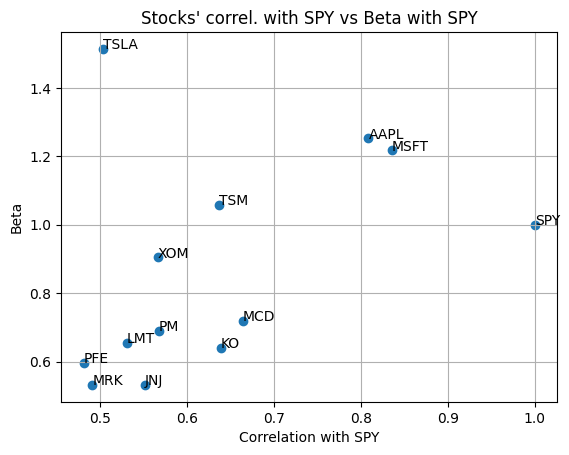

In [10]:
# Scatter plot: Correl with SPY vs Beta
plt.scatter(correl_with_SPY_map.values(), beta_map.values())

# Set labels
plt.xlabel("Correlation with SPY"), plt.ylabel("Beta")

# Put label on each point
for label, correl in correl_with_SPY_map.items():
    beta = beta_map[label]
    plt.annotate(label, (correl, beta))

# Add grids to show quadrants
# Ideally, we want to hold stocks that are scattered across, covering as many quandrants as possible
plt.grid()

# Set title
plt.title("Stocks' correl. with SPY vs Beta with SPY");
